In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [2]:
# 1. Data Preprocessing
# Load the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
df = pd.read_csv(url, encoding='iso-8859-1')

# Convert 'Date' to datetime, specifying the format and dayfirst=True
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True)

# Handle missing values 
print("Missing values:\n", df.isnull().sum())

# Handle outliers (using IQR method for 'Rented Bike Count')
Q1 = df['Rented Bike Count'].quantile(0.25)
Q3 = df['Rented Bike Count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Rented Bike Count'] >= lower_bound) & (df['Rented Bike Count'] <= upper_bound)]


Missing values:
 Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64


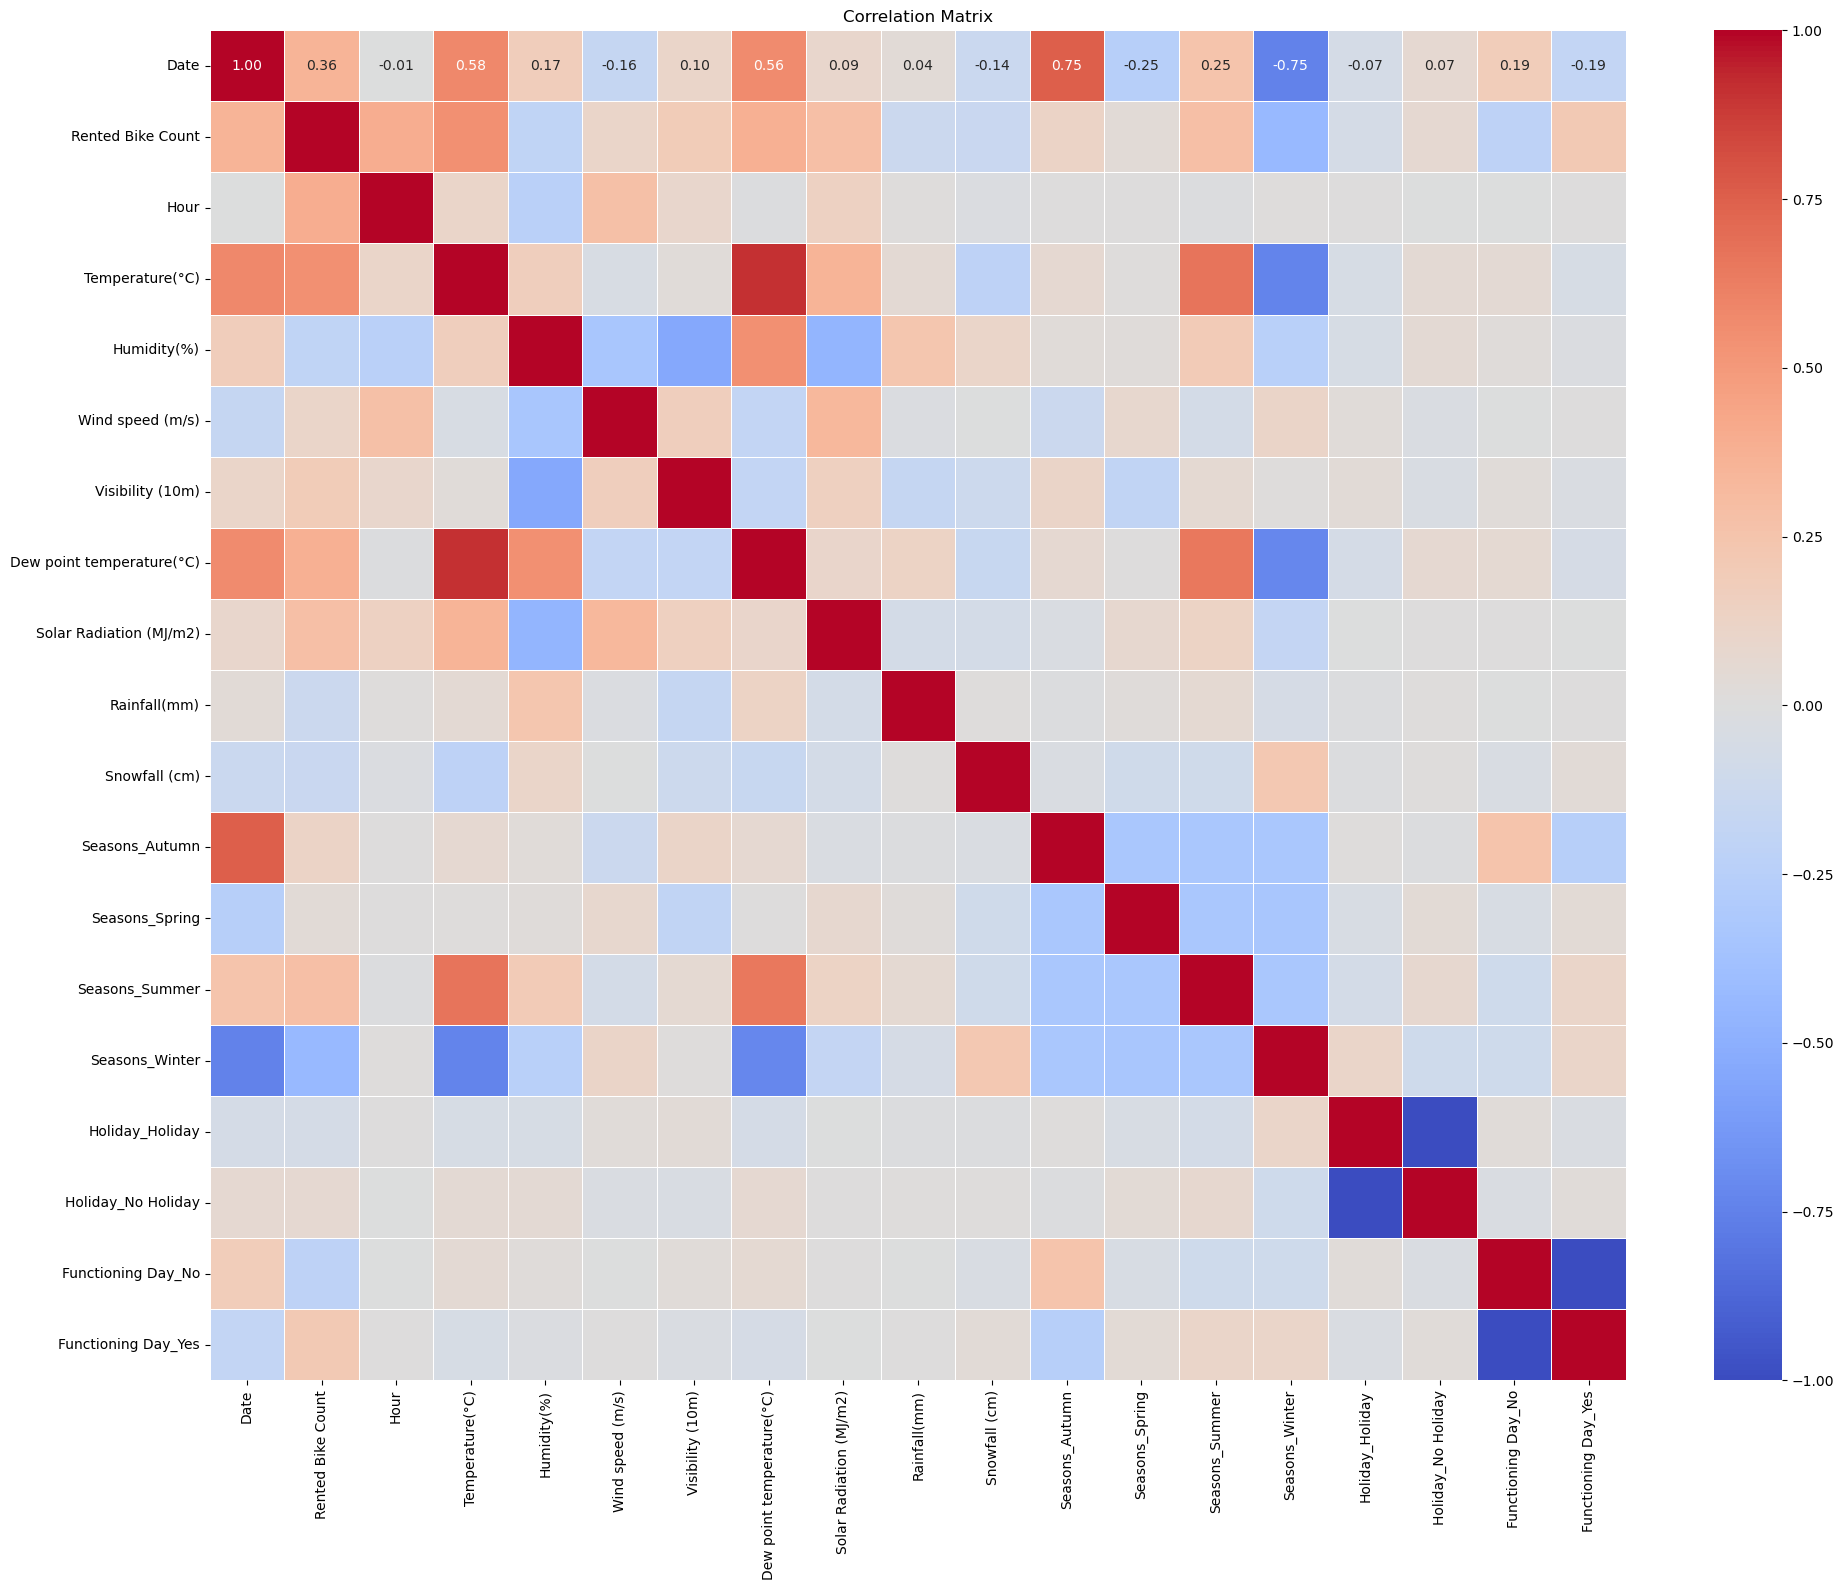


Basic statistics for numerical columns:
                                Date  Rented Bike Count         Hour  \
count                           8602        8602.000000  8602.000000   
mean   2018-05-31 08:10:49.523366656         667.971635    11.377122   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-02-28 00:00:00         188.000000     5.000000   
50%              2018-05-30 00:00:00         485.000000    11.000000   
75%              2018-08-31 00:00:00        1030.750000    17.000000   
max              2018-11-30 00:00:00        2375.000000    23.000000   
std                              NaN         589.552620     6.920938   

       Temperature(°C)  Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
count      8602.000000  8602.000000       8602.000000       8602.000000   
mean         12.674890    58.372937          1.716124       1431.978958   
min         -17.800000     0.000000          0.000000         27.000000   
25%       

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


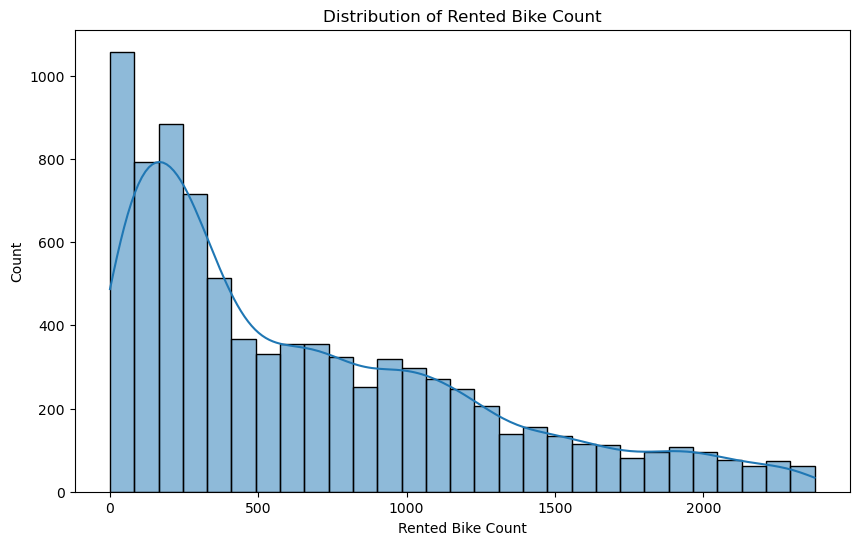

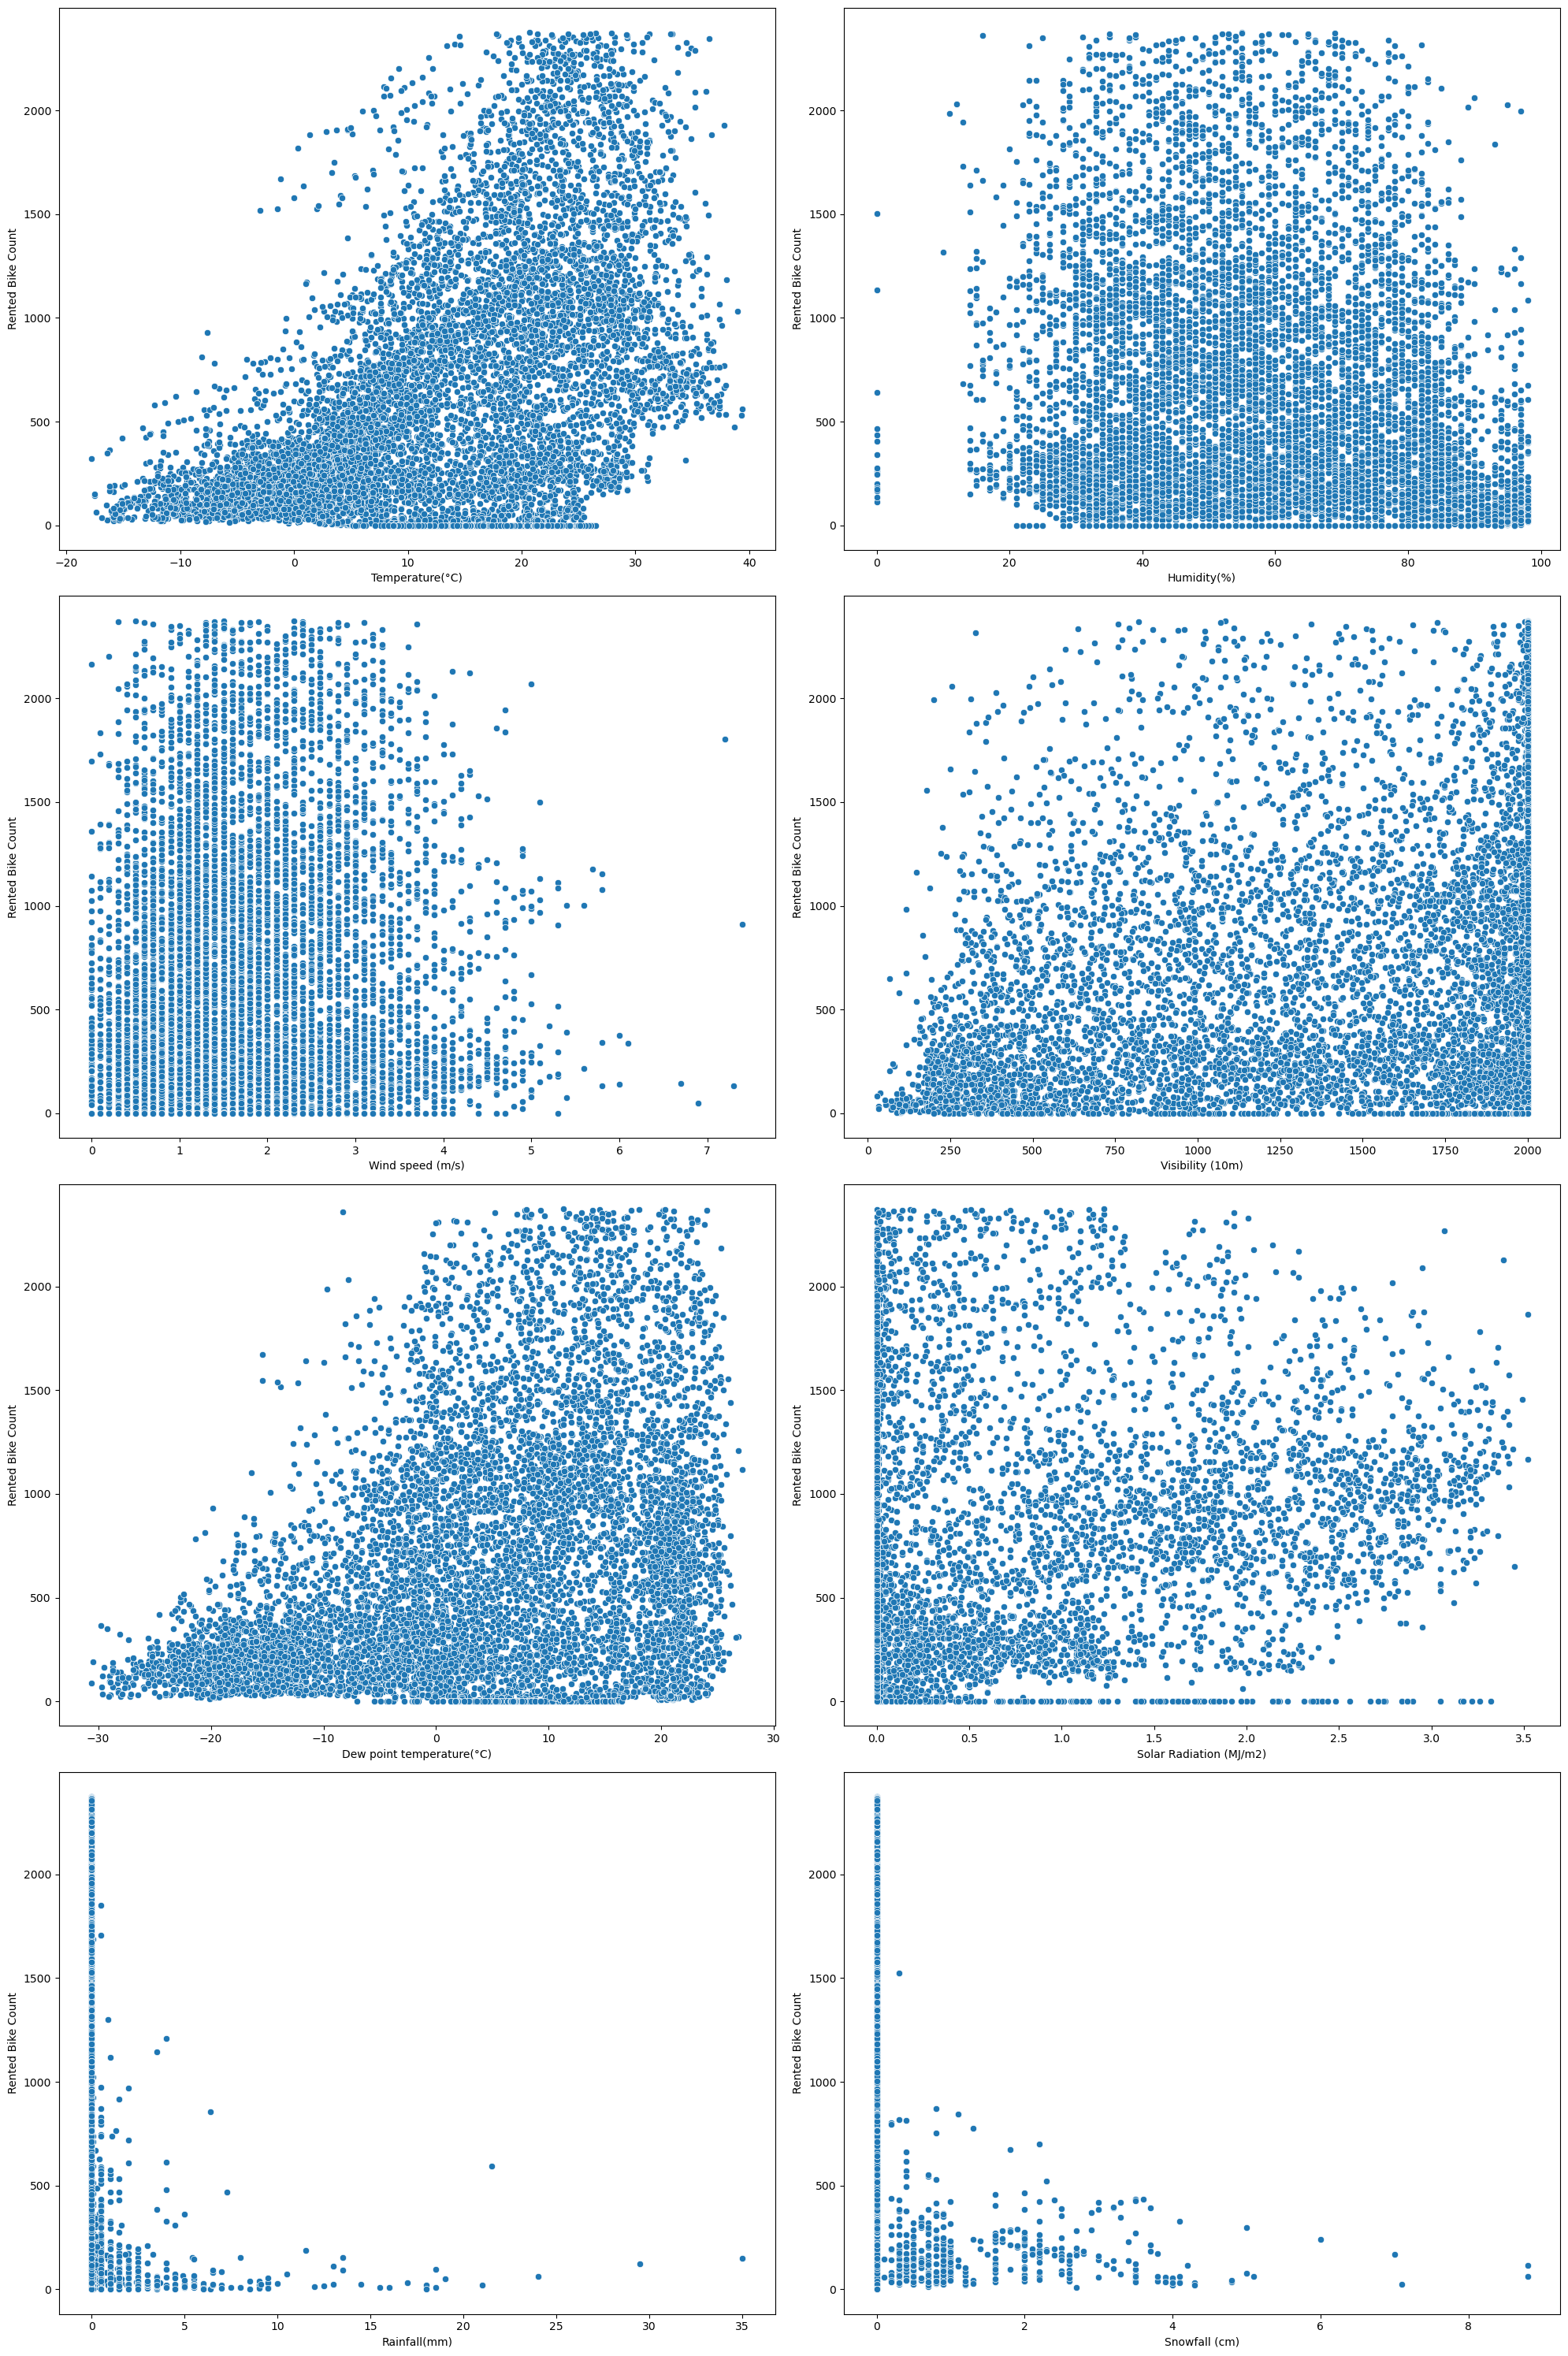

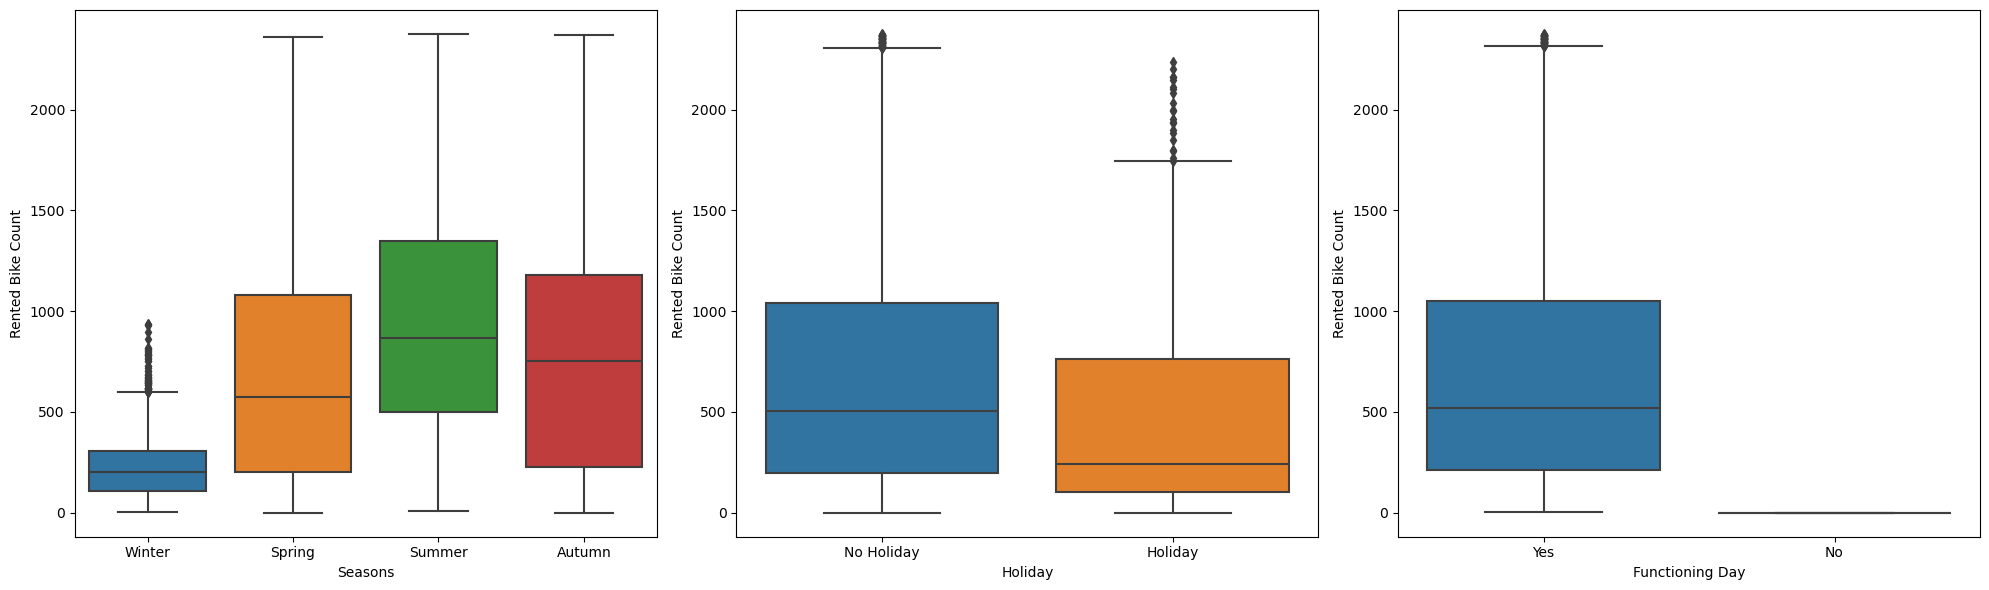

In [3]:
# 2. Exploratory Data Analysis (EDA)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
# Handle categorical variables
categorical_columns = ['Seasons', 'Holiday', 'Functioning Day']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Create correlation matrix
plt.figure(figsize=(20, 16))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Display basic statistics
print("\nBasic statistics for numerical columns:")
print(df.describe())

# Display info about categorical columns
print("\nUnique values in categorical columns:")
for col in categorical_columns:
    print(f"\n{col}:")
    print(df[col].value_counts())

# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Rented Bike Count'], kde=True)
plt.title("Distribution of Rented Bike Count")
plt.show()

# Scatter plots of numerical features vs target
numerical_features = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 
                      'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

fig, axes = plt.subplots(4, 2, figsize=(20, 30))
for i, feature in enumerate(numerical_features):
    sns.scatterplot(data=df, x=feature, y='Rented Bike Count', ax=axes[i//2, i%2])
plt.tight_layout()
plt.show()

# Box plots for categorical features
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=df, x='Seasons', y='Rented Bike Count', ax=axes[0])
sns.boxplot(data=df, x='Holiday', y='Rented Bike Count', ax=axes[1])
sns.boxplot(data=df, x='Functioning Day', y='Rented Bike Count', ax=axes[2])
plt.tight_layout()
plt.show()

In [13]:
# 3. Quality of Fit for (a) In-Sample, (b) Validation (80-20 train-test-split), (c) 5x Cross-Validation
# Prepare the data
X = df.drop(['Rented Bike Count', 'Date'], axis=1)
y = df['Rented Bike Count']

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# (a) In-Sample Validation
model_in_sample = LinearRegression()
model_in_sample.fit(X_scaled, y)
y_pred_in_sample = model_in_sample.predict(X_scaled)
r2_in_sample = r2_score(y, y_pred_in_sample)
mse_in_sample = mean_squared_error(y, y_pred_in_sample)

print("In-Sample Validation:")
print(f"R-squared: {r2_in_sample}")
print(f"Mean Squared Error: {mse_in_sample}")

# (b) 80-20 Train-Test Split Validation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model_split = LinearRegression()
model_split.fit(X_train, y_train)
y_pred_split = model_split.predict(X_test)
r2_split = r2_score(y_test, y_pred_split)
mse_split = mean_squared_error(y_test, y_pred_split)

print("\n80-20 Train-Test Split Validation:")
print(f"R-squared: {r2_split}")
print(f"Mean Squared Error: {mse_split}")

# (c) 5x Cross-Validation
model_cv = LinearRegression()
cv_scores = cross_val_score(model_cv, X_scaled, y, cv=5, scoring='r2')

print("\n5x Cross-Validation:")
print(f"R-squared (mean): {np.mean(cv_scores)}")
print(f"R-squared (std): {np.std(cv_scores)}")

In-Sample Validation:
R-squared: 0.5591971844546493
Mean Squared Error: 153193.03351809664

80-20 Train-Test Split Validation:
R-squared: 0.566498500805987
Mean Squared Error: 157188.7661298376

5x Cross-Validation:
R-squared (mean): -0.35208033744207856
R-squared (std): 1.272429736282899


                            OLS Regression Results                            
Dep. Variable:      Rented Bike Count   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     778.1
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:55:16   Log-Likelihood:                -63557.
No. Observations:                8602   AIC:                         1.271e+05
Df Residuals:                    8587   BIC:                         1.273e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        667.9716      4.224    158.146      0.0

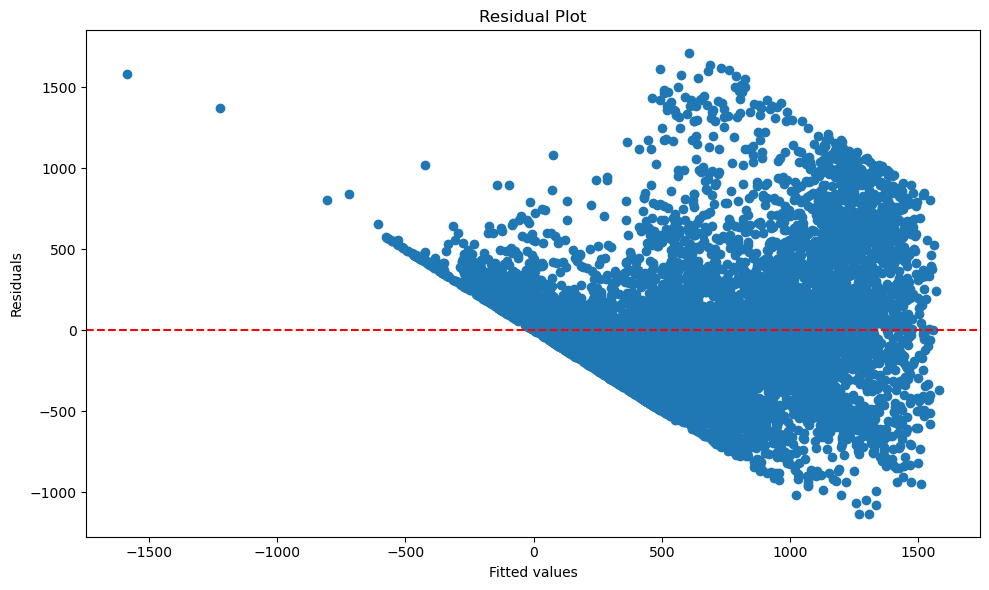

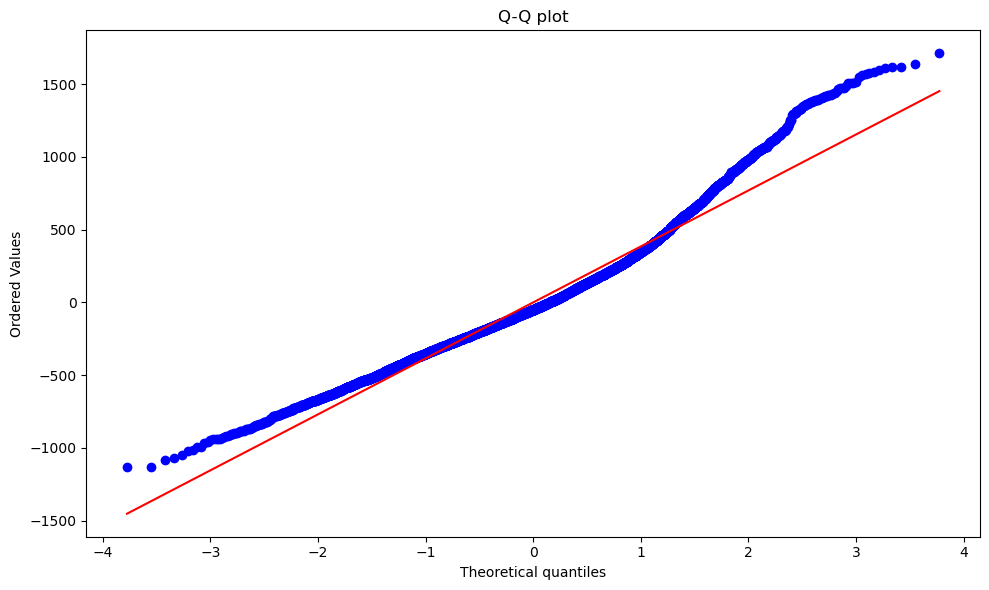

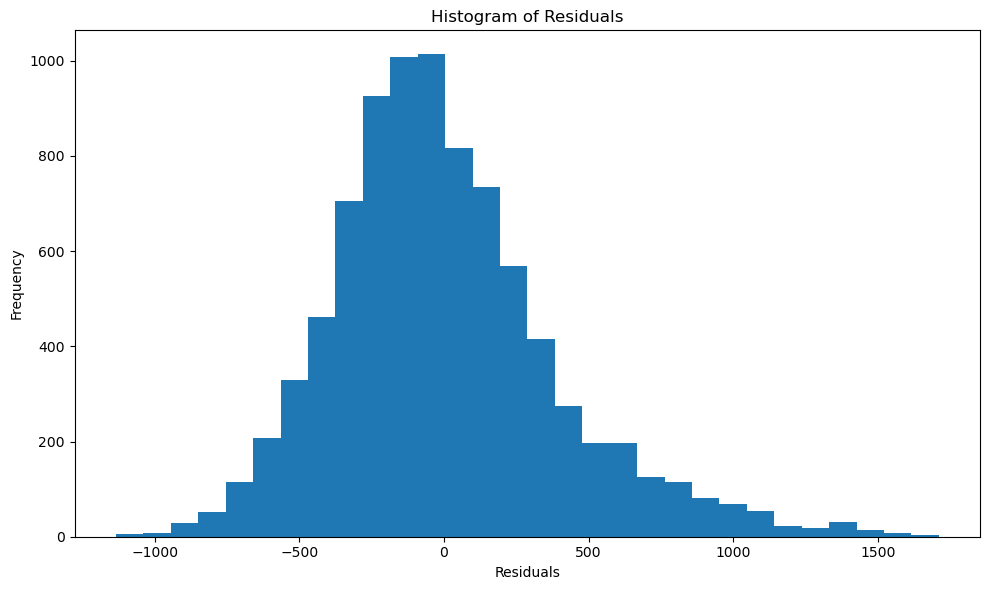

In [15]:
# 4. Statistical Summaries and Plots
import numpy as np
import pandas as pd
import statsmodels.api as sm  # Importing statsmodels
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Drop the 'Date' column and 'Rented Bike Count' (target)
X = df.drop(columns=['Rented Bike Count', 'Date'])

# Ensure categorical variables are encoded (e.g., 'Seasons', 'Holiday', 'Functioning Day')
X = pd.get_dummies(X, columns=['Seasons', 'Holiday', 'Functioning Day'], drop_first=True)

# Define the target variable
y = df['Rented Bike Count']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a statsmodels OLS model for summary statistics
X_with_const = sm.add_constant(X_scaled)  # Add constant for intercept
model_summary = sm.OLS(y, X_with_const).fit()
print(model_summary.summary())

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(model_summary.fittedvalues, model_summary.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Q-Q plot
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(model_summary.resid, dist="norm", plot=ax)
ax.set_title("Q-Q plot")
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(model_summary.resid, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.show()


Linear Regression Results:
Train MSE: 152275.1143
Train R²: 0.5570
Test MSE: 157188.7661
Test R²: 0.5665
CV MSE: 153176.5530


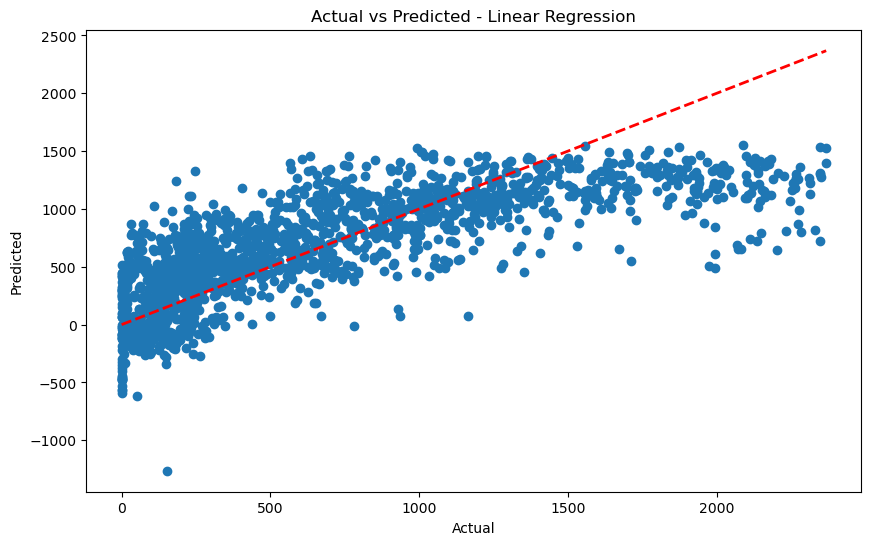

In [10]:
#Linear Regression 
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train_aligned)

# In-sample performance (Training set)
train_pred = model.predict(X_train_scaled)
train_mse = mean_squared_error(y_train_aligned, train_pred)
train_r2 = r2_score(y_train_aligned, train_pred)

# Align y_test to match X_test_scaled
y_test_aligned = y_test.iloc[:1721]

# Validation performance (using aligned y_test)
test_pred = model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test_aligned, test_pred)
test_r2 = r2_score(y_test_aligned, test_pred)

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train_aligned, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()

# Print results
print("Linear Regression Results:")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"CV MSE: {cv_mse:.4f}")

# Plot actual vs predicted for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test_aligned, test_pred)
plt.plot([y_test_aligned.min(), y_test_aligned.max()], [y_test_aligned.min(), y_test_aligned.max()], 'r--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted - Linear Regression")
plt.show()

Ridge Regression Results:
Train MSE: 152275.1772
Train R2: 0.5570
Test MSE: 157183.6720
Test R2: 0.5665
CV MSE: 153173.5171


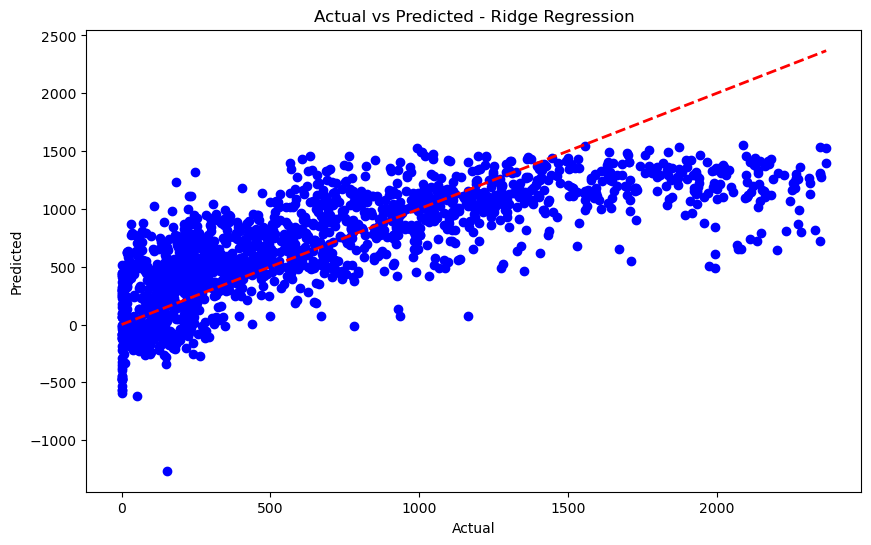

In [11]:
# 4. Ridge Regression 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import pandas as pd

# Align y_train to match the number of rows in X_train_scaled
y_train_aligned = y_train.iloc[:6881]

# Align y_test to match the number of rows in X_test_scaled (if necessary)
y_test_aligned = y_test.iloc[:1721]  # Adjust based on your dataset

# Create and train the Ridge Regression model
model = Ridge(alpha=1.0)  # Adjust alpha if needed
model.fit(X_train_scaled, y_train_aligned)

# In-sample performance (Training set)
train_pred = model.predict(X_train_scaled)
train_mse = mean_squared_error(y_train_aligned, train_pred)
train_r2 = r2_score(y_train_aligned, train_pred)

# Validation performance (Test set)
test_pred = model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test_aligned, test_pred)
test_r2 = r2_score(y_test_aligned, test_pred)

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train_aligned, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()

# Print results
print("Ridge Regression Results:")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train R2: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"CV MSE: {cv_mse:.4f}")

# Plot actual vs predicted values for the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test_aligned, test_pred, color='blue')

# Plot a red dashed line representing perfect predictions
plt.plot([y_test_aligned.min(), y_test_aligned.max()], [y_test_aligned.min(), y_test_aligned.max()], 'r--', lw=2)

# Label the axes
plt.xlabel("Actual")
plt.ylabel("Predicted")

# Set the title
plt.title("Actual vs Predicted - Ridge Regression")

# Show the plot
plt.show()

Lasso Regression Results:
Train MSE: 415701.9256
Train R2: 0.0006
Test MSE: 418059.2986
Test R2: -0.0004
CV MSE: 417771.7270


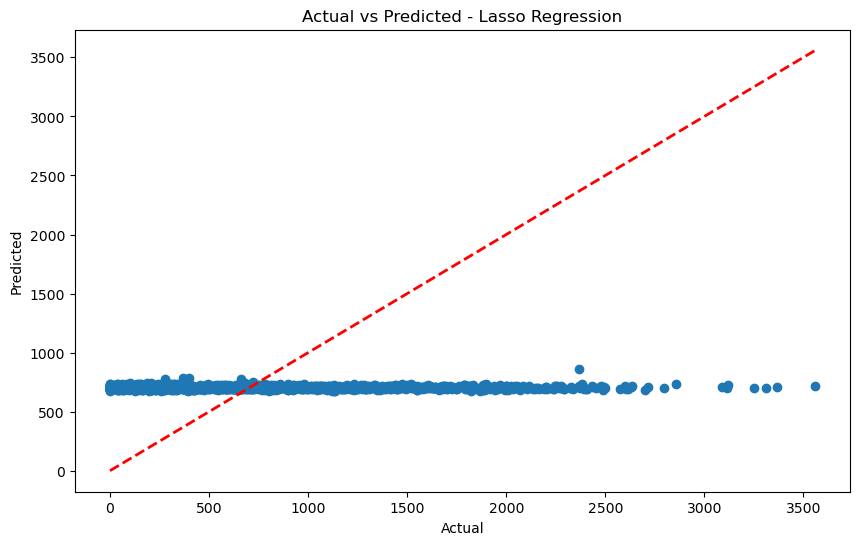

In [115]:
# Lasso Regression 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Align y_train to match the number of rows in X_train_scaled
y_train_aligned = y_train.iloc[:6881]

# Align y_test to match the number of rows in X_test_scaled (if necessary)
y_test_aligned = y_test.iloc[:1721]  # Adjust based on actual dataset

# Create and train the Lasso Regression model
model = Lasso(alpha=1.0)  # Adjust alpha as needed
model.fit(X_train_scaled, y_train_aligned)

# In-sample performance (Training set)
train_pred = model.predict(X_train_scaled)
train_mse = mean_squared_error(y_train_aligned, train_pred)
train_r2 = r2_score(y_train_aligned, train_pred)

# Validation performance (Test set)
test_pred = model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test_aligned, test_pred)
test_r2 = r2_score(y_test_aligned, test_pred)

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train_aligned, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()

# Print results
print("Lasso Regression Results:")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train R2: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"CV MSE: {cv_mse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_aligned, test_pred)
plt.plot([y_test_aligned.min(), y_test_aligned.max()], [y_test_aligned.min(), y_test_aligned.max()], 'r--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted - Lasso Regression")
plt.show()


Mean Squared Error: 206819.8226
R-squared Score: 0.5036


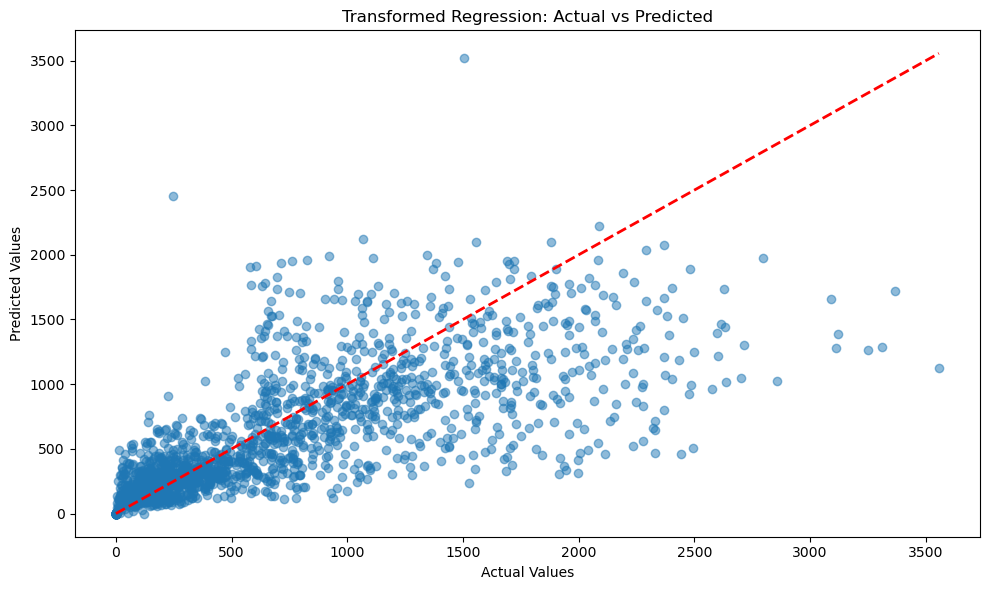

In [1]:
# Transformed Regression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and preprocess the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
df = pd.read_csv(url, encoding='unicode_escape')
X = df.drop(columns=['Rented Bike Count', 'Date'])
X = pd.get_dummies(X, columns=['Seasons', 'Holiday', 'Functioning Day'], drop_first=True)
y = df['Rented Bike Count']

# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model and make predictions
model = LinearRegression().fit(X_train_scaled, np.log1p(y_train))
y_pred = np.expm1(model.predict(X_test_scaled))

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Create actual vs predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Transformed Regression: Actual vs Predicted')
plt.tight_layout()
plt.show()


Mean Squared Error: 220174.1358
R-squared Score: 0.4716


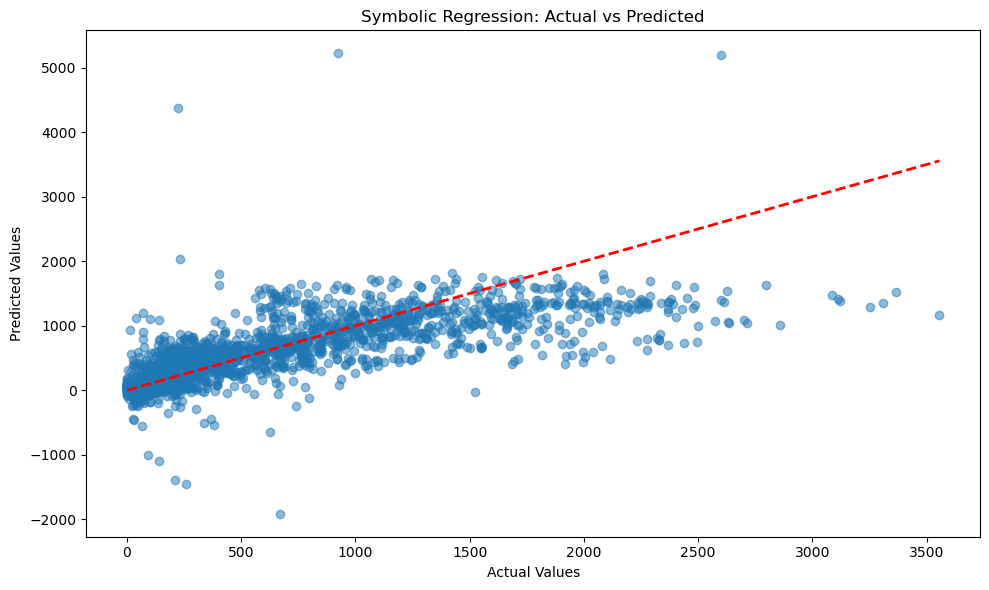

Best Symbolic Expression:
sub(mul(add(add(add(add(div(0.817, X13), X7), sub(X1, X8)), X7), sub(X1, X8)), add(div(add(div(0.817, X13), add(X0, div(0.007, X6))), mul(X7, X8)), add(X6, add(add(X5, sub(X5, X11)), sub(X5, X11))))), sub(div(add(add(add(div(0.817, X13), X7), add(add(X5, X11), X5)), X7), mul(X7, X8)), div(div(X6, X6), sub(X8, -0.244))))


In [2]:
# Symbolic Regression 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from gplearn.genetic import SymbolicRegressor
import matplotlib.pyplot as plt

# Load and preprocess the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
df = pd.read_csv(url, encoding='unicode_escape')
X = df.drop(columns=['Rented Bike Count', 'Date'])
X = pd.get_dummies(X, columns=['Seasons', 'Holiday', 'Functioning Day'], drop_first=True)
y = df['Rented Bike Count']

# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model and make predictions
model = SymbolicRegressor(population_size=5000, generations=20, function_set=['add', 'sub', 'mul', 'div'],
                          metric='mean absolute error', random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Create actual vs predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Symbolic Regression: Actual vs Predicted')
plt.tight_layout()
plt.show()

# Print the best symbolic expression
print("Best Symbolic Expression:")
print(model._program)


In [19]:
# 8. Feature Selection 
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame with the dataset

# Drop the 'Date' column and 'Rented Bike Count' (target)
X = df.drop(columns=['Rented Bike Count', 'Date'])

# Ensure categorical variables are encoded (e.g., 'Seasons', 'Holiday', 'Functioning Day')
X = pd.get_dummies(X, columns=['Seasons', 'Holiday', 'Functioning Day'], drop_first=True)

# Define the target variable
y = df['Rented Bike Count']

# Convert bool columns to int (1 or 0)
X = X.astype(int)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Forward Selection
sfs_forward = SequentialFeatureSelector(LinearRegression(), n_features_to_select=5, direction='forward')
sfs_forward.fit(X_scaled, y)
selected_features_forward = X.columns[sfs_forward.get_support()].tolist()

print("Forward Selection:")
print(selected_features_forward)

# Backward Selection
sfs_backward = SequentialFeatureSelector(LinearRegression(), n_features_to_select=5, direction='backward')
sfs_backward.fit(X_scaled, y)
selected_features_backward = X.columns[sfs_backward.get_support()].tolist()

print("\nBackward Selection:")
print(selected_features_backward)

# Stepwise Selection (using statsmodels)
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # Backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        # Use all p-values except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Run stepwise selection after data has been cleaned
stepwise_features = stepwise_selection(X, y)
print("\nStepwise Selection:")
print(stepwise_features)


Forward Selection:
['Temperature(°C)', 'Visibility (10m)', 'Seasons_Summer', 'Holiday_No Holiday', 'Functioning Day_Yes']

Backward Selection:
['Dew point temperature(°C)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons_Winter', 'Functioning Day_Yes']
Add  Temperature(°C)                with p-value 0.0
Add  Hour                           with p-value 0.0
Add  Functioning Day_Yes            with p-value 3.83916e-192
Add  Humidity(%)                    with p-value 2.53801e-155
Add  Seasons_Winter                 with p-value 8.11021e-108
Add  Rainfall(mm)                   with p-value 6.02432e-45
Add  Solar Radiation (MJ/m2)        with p-value 1.95674e-23
Add  Seasons_Spring                 with p-value 1.2216e-15
Add  Seasons_Summer                 with p-value 1.97124e-23
Add  Holiday_No Holiday             with p-value 5.5124e-07

Stepwise Selection:
['Temperature(°C)', 'Hour', 'Functioning Day_Yes', 'Humidity(%)', 'Seasons_Winter', 'Rainfall(mm)', 'Solar Radiation (MJ/m2)', 'Seasons_S